In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from torch.utils.data import TensorDataset
from transformers import BertTokenizer

In [ ]:
from google.colab import files
upload= files.upload()

Saving finalset.xlsx to finalset.xlsx


In [ ]:
df= pd.read_excel("finalset.xlsx")
category_map={
    "Knowledge": 0,
    "Comprehension": 1,
    "Application": 2,
    "Analysis": 3,
    "Synthesis": 4,
    "Evaluation": 5
}
df["category"]=df["category"].map(category_map)
df.to_excel("final.xlsx",index=False)

In [ ]:
df.head()

,category,text
0,0,List two reference parameters in the setHour ...
1,0,Explain briefly the meaning of the following ...
2,0,Label the parts of the diagram
3,0,"4. Based on the above dataType class, list all..."
4,0,5. Define morphology


In [ ]:
df['category'].value_counts()

4    130
0    126
5    124
1    123
3    123
2    115
Name: category, dtype: int64

In [ ]:
tokenizer= BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
token = tokenizer.encode_plus(
    df['text'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))


In [ ]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
labels = np.zeros((len(df), 6))
labels.shape

(741, 6)

In [ ]:
labels[np.arange(len(df)), df['category'].values] = 1

In [ ]:
labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [ ]:
def BloomsDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(BloomsDatasetMapFunction)

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>

In [ ]:
p=0.8
train_size=int((len(df)//16)*p)

In [ ]:
train_size

36

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)
len(train_dataset),len(val_dataset)

(36, 10)

In [ ]:
from transformers import TFBertModel
from transformers import TFBertTokenizer

In [ ]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

#model = TFAutoModelForSequenceClassification.from_pretrained('albert-base-v2')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(6, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

Blooms_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
Blooms_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
Blooms_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
hist = Blooms_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
36/36 [==============================] - 2309s 63s/step - loss: 1.7719 - accuracy: 0.2240 - val_loss: 1.6224 - val_accuracy: 0.3187
Epoch 2/5
36/36 [==============================] - 2224s 62s/step - loss: 1.5620 - accuracy: 0.4271 - val_loss: 1.3255 - val_accuracy: 0.5437
Epoch 3/5
36/36 [==============================] - 2231s 62s/step - loss: 1.2321 - accuracy: 0.5885 - val_loss: 0.9925 - val_accuracy: 0.7188
Epoch 4/5
36/36 [==============================] - 2228s 62s/step - loss: 0.9174 - accuracy: 0.7292 - val_loss: 0.6464 - val_accuracy: 0.8188
Epoch 5/5
36/36 [==============================] - 2225s 62s/step - loss: 0.6228 - accuracy: 0.8229 - val_loss: 0.3826 - val_accuracy: 0.9062


In [ ]:
print(tf.__version__)

2.11.0


In [ ]:
#save model

!mkdir /content/gdrive/My\ Drive/Colab_Models

mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab_Models’: No such file or directory


In [ ]:
# model.save('/content/gdrive/My Drive/Colab_Models/model_{}.h5'.format(e))

In [ ]:
Blooms_model.save('blooms_model_1')

In [ ]:
model.save_weights("BloomsModel.h5")


In [ ]:
blooms_model = tf.keras.models.load_model('blooms_model_1')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['Knowledge', 'Comprehension', 'Application', 'Analysis', 'Synthesis','Evaluation']):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

In [ ]:
exam=input("enter the examination(T1,T2,T3): ")
if exam=='T1':
   i=0
   e=0
   m=0
   h=0
   while i<=20:
     input_text = input('Enter your question: ')
     processed_data = prepare_data(input_text, tokenizer)
     result = make_prediction(blooms_model, processed_data=processed_data)
     print(f"Predicted Level: {result}")
     if result=='Knowledge':
       print("maximum marks for this level=2")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1    
       i+=marks
     elif result=='Comprehension':
       print(f"maximum marks for this level= 3")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
       i+=marks
     elif result=='Application':
       print(f"maximum marks for this level= 4")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
       i+=marks
     elif result=='Analysis':
       print(f"maximum marks for this level= 4")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
       i+=marks
     elif (result=='Synthesis'):
       print(f"maximum marks for this level= 5")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
       i+=marks
     elif (result=='Evaluation'):
       print(f"maximum marks for this level= 5")  
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
       i+=marks
elif exam=='T3':
   while i<=36:

     input_text= input("enter your question: ")
     processed_data = prepare_data(input_text,tokenizer)
     result= make_prediction(blooms_model,processed_data=processed_data)
     print(f"Predicted Level: {result}")
     if (result=='Knowledge'):
       print("maximum marks for this level=2")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       elif level=='hard':
         h+=1 
       else:
         print("Invalid difficulty level!")
       i+=marks
     elif (result=='Comprehension'):
       print(f"maximum marks for this level= 3")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
       i+=marks
     elif (result=='Application'):
       print(f"maximum marks for this level= 4")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       elif level=='hard':
         h+=1 
       else:
         print("Invalid difficulty level!")
         break
       i+=marks
     elif (result=='Analysis'):
       print(f"maximum marks for this level= 4")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
       i+=marks
     elif (result=='Synthesis'):
       print(f"maximum marks for this level= 5")
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
         break
       i+=marks
     elif (result=='Comprehension'):
       print(f"maximum marks for this level= 5")  
       marks=int(input("enter marks:"))
       level=input("enter difficulty level:")
       if level=='easy':
         e+=1
       elif level=='medium':
         m+=1
       else:
         h+=1 
       i+=marks       


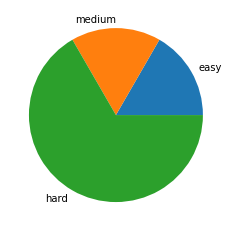

In [ ]:
import matplotlib.pyplot as plt
y = np.array([e,m,h])  
difficulty_levels=['easy','medium','hard']
plt.pie(y,labels=difficulty_levels)
plt.show()